# TP4
El archivo data.csv contiene una lista de publicaciones de fisica de altas energias del repositorio ArXiv. En esta practica vamos a estudiar el grafo de colaboraciones entre autores, en el que los nodos representan autores y las aristas coautorias. Vamos a usar un grafo simple no dirigido, en el que basta una coautoria para que haya una conexion entre dos autores.

Imports

In [259]:
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import networkx as nx
import itertools
import random
import math
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
sns.plt = plt

## 1. Creacion del Grafo
A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el numero de nodos y aristas. Haga una representacion grafica del grafo.

Lectura de datos

In [175]:
df = pd.read_csv('data.csv',
                 header=None,
                 names=['year', 'journal', 'media', 'authors', 'paper_name'],
                 usecols=['authors'])

# print df

Preprocesamiento - Creacion del grafo

In [232]:
coauthor_graph = nx.Graph()
for index, row in df.iterrows():
    paper_authors = row['authors'].split("&")
    paper_authors = map(lambda x: x.strip(),paper_authors)
    paper_authors_pairs = list(itertools.combinations(paper_authors, 2))
    coauthor_graph.add_nodes_from(paper_authors)
    coauthor_graph.add_edges_from(paper_authors_pairs)

Imprimir el numero de nodos y aristas.

In [233]:
print "Numero de nodos: " + str(coauthor_graph.number_of_nodes())
print "Numero de aristas: " + str(coauthor_graph.number_of_edges())

Numero de nodos: 3986
Numero de aristas: 7845


Hacer una representacion grafica del grafo.

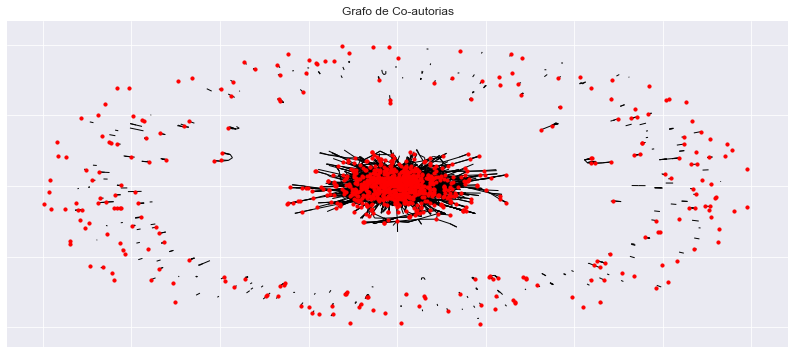

In [256]:
nodes_visible = random.sample(coauthor_graph.nodes(), 1000)
nx.draw_networkx(coauthor_graph, with_labels=False, node_size=10, nodelist = nodes_visible)
plt.tick_params(axis='x', labelbottom='off')
plt.tick_params(axis='y', labelleft='off')
plt.title("Grafo de Co-autorias")
plt.rcParams["figure.figsize"] = [14,6]
plt.show()

## 2. Distribucion de Grado
Grafique la distribucion del grado de los autores, en escalas lineales, semilogaritmica, y log-log. Argumente, a partir de los graficos, de que tipo de distribucion se trata.

In [234]:
author_degree_list = list(coauthor_graph.degree())
degree_list = [degree for (author, degree) in author_degree_list]

degree_frequencies = Counter(degree_list)
print degree_frequencies

Counter({1: 824, 2: 799, 3: 561, 4: 356, 0: 303, 5: 285, 6: 188, 7: 135, 8: 108, 9: 86, 10: 68, 13: 38, 12: 37, 11: 36, 14: 32, 15: 29, 17: 22, 16: 11, 18: 10, 22: 10, 20: 8, 21: 8, 19: 7, 23: 6, 24: 3, 26: 3, 25: 2, 27: 2, 28: 2, 35: 2, 31: 1, 34: 1, 39: 1, 40: 1, 55: 1})


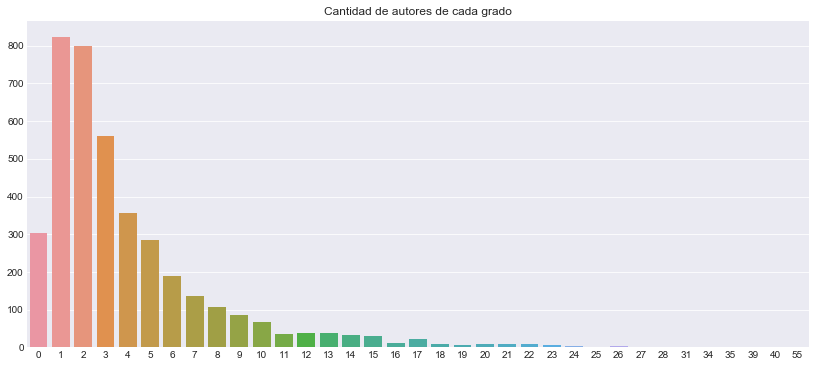

In [338]:
sns.barplot(degree_frequencies.keys(), y=degree_frequencies.values())
plt.title("Cantidad de autores de cada grado")
plt.show()

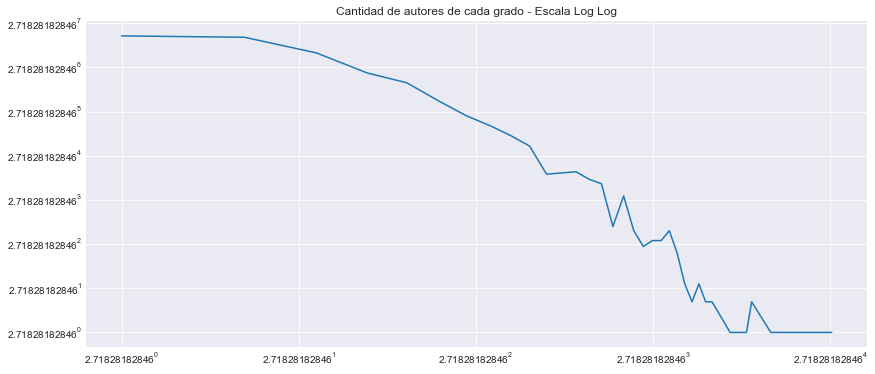

In [343]:
plt.loglog(degree_frequencies.keys(), degree_frequencies.values(), basex=np.e, basey=np.e)
plt.title("Cantidad de autores de cada grado - Escala Log Log")
plt.show()

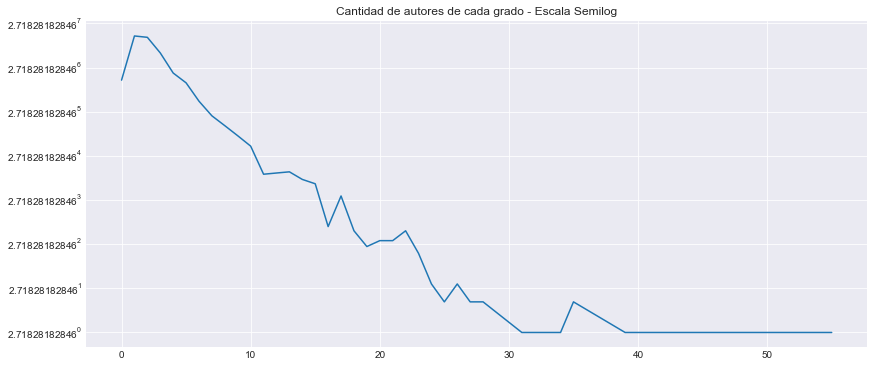

In [263]:
plt.semilogy(degree_frequencies.keys(), degree_frequencies.values(), basey=np.e)
plt.title("Cantidad de autores de cada grado - Escala Semilog")
plt.show()

### Tipo de distribucion: 
1. Hacemos cutoff de primer y ultimo 10% de los datos
2. Calculamos, via regresion lineal, cual de las dos escalas tiene mayor correlacion lineal entre los ejex X e Y y menor error.

In [356]:
# Cutoff
key_quantity = len(degree_frequencies.keys())
linx = degree_frequencies.keys()[key_quantity/10:key_quantity*9/10]
loglogx = np.log(degree_frequencies.keys()[key_quantity/10:key_quantity*9/10])
loglogy = np.log(degree_frequencies.values()[key_quantity/10:key_quantity*9/10])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(loglogx, loglogy)
print "Coeficiente de correlacion lineal Escala Log Log: " + str(r_value)
print "Error Escala Log Log: " + str(std_err)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(linx, loglogy)
print "Coeficiente de correlacion lineal Escala Semilog: " + str(r_value)
print "Error Escala Semilog: " + str(std_err)

Coeficiente de correlacion lineal Escala Log Log: -0.972041444324
Error Escala Log Log: 0.130107907027
Coeficiente de correlacion lineal Escala Semilog: -0.983719768678
Error Escala Semilog: 0.00744721052593


Como podemos ver, la Escala Semilog produce un resultado mas parecido a una funcion lineal, ya que tiene
tanto mejor correlacion lineal como menor error.
Por lo tanto, concluimos que la funcion es de tipo Exponencial.

## 3. Componentes Conexas
Calcule el numero de componentes conexas del grafo. Muestre el tamano de la componente mayor, o componente gigante.

In [238]:
connected_components = nx.connected_components(coauthor_graph)
max_size = 0
count = 0
gig_comp = []
for comp in connected_components:
    if (len(comp) > max_size):
        max_size = len(comp)
        gig_comp = comp
    count += 1

print "Hay " + str(count) + " componentes conexas."
print "La mayor componente conexa tiene " + str(max_size) + " nodos."

Hay 539 componentes conexas.
La mayor componente conexa tiene 2998 nodos.


## 4. Tamanos de Vecindades
Trabajando con la componente gigante del grafo, estudie, parandose en un nodo al azar, como aumenta el numero de autores alcanzados a medida que se aleja del nodo semilla. Grafique el numero de autores alcanzados en funcion de la distancia al nodo semilla. Grafique tambien el numero de nuevos autores que se agregan en cada paso, y estime el maximo de esta funcion. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los graficos y su relacion con el fenomeno de seis grados de separacion.

Selected nodes: ['Falceto', 'Lesgourgues', 'Nima', 'Hawking']


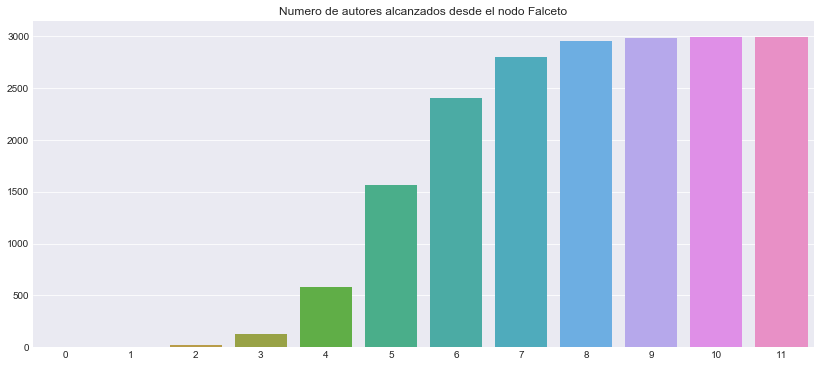

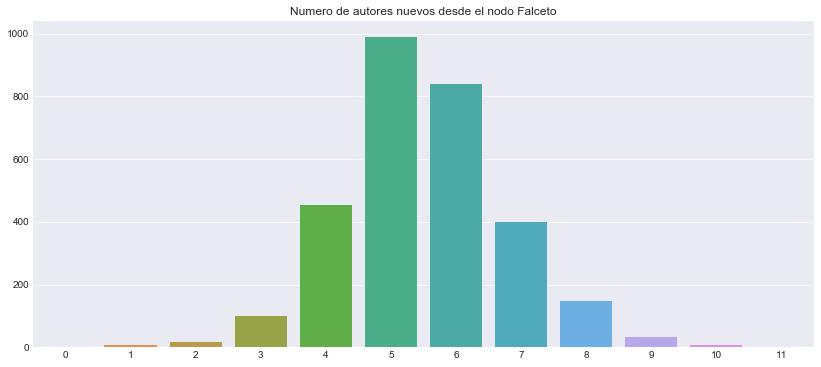

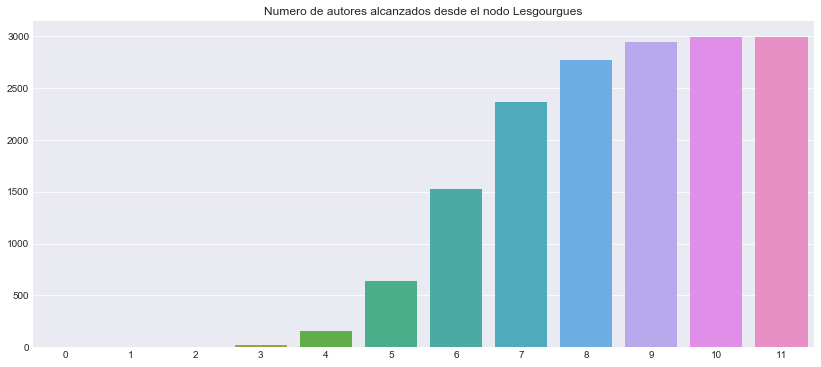

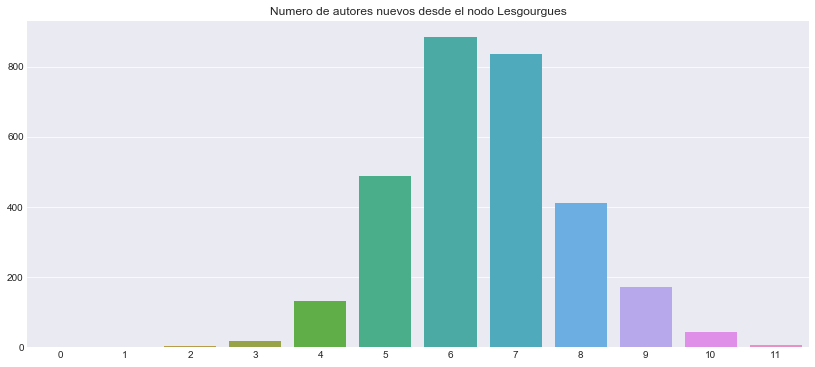

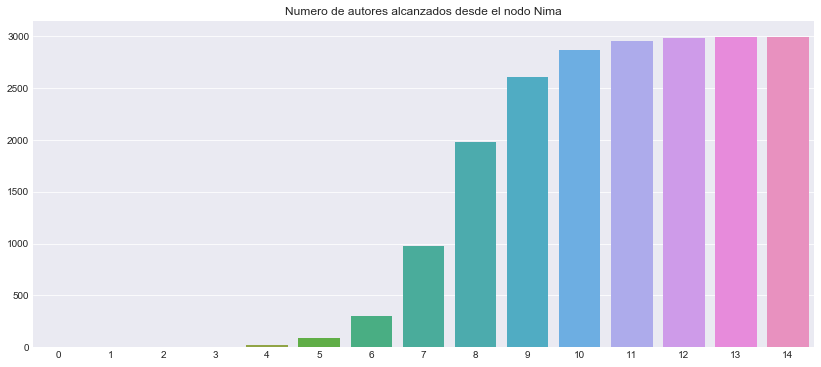

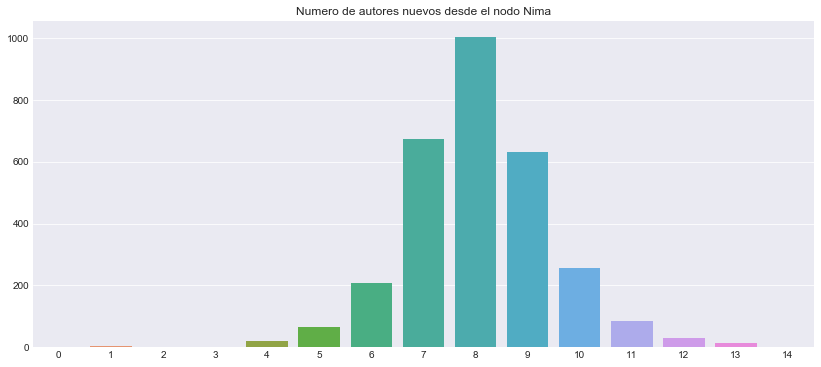

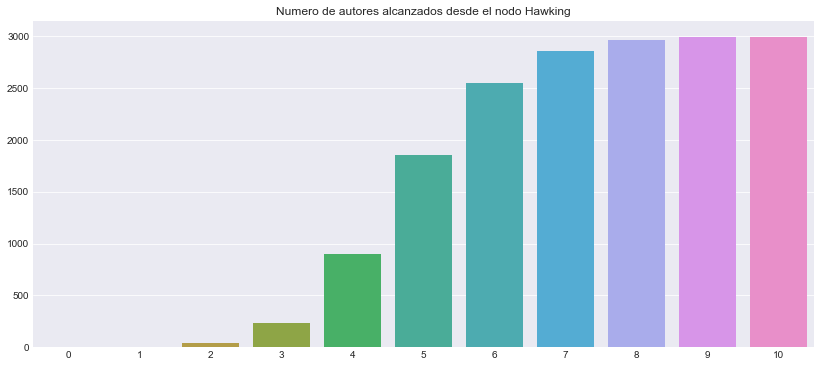

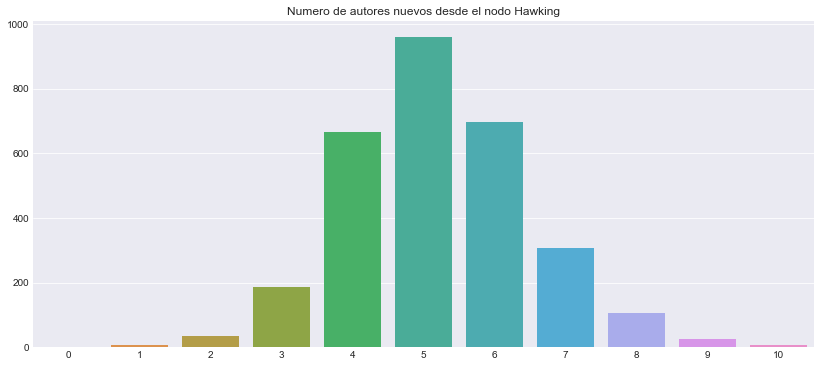

In [239]:
# Definimos grafo componente gigante
gig_comp_graph = coauthor_graph.subgraph(gig_comp)

# Seleccionamos 3 nodos random usando random.org y le agregamos a Stephen Hawking
selected_nodes = [list(gig_comp_graph.nodes())[i] for i in [182,202,1083]]
selected_nodes.append("Hawking")
print "Selected nodes: " + str(selected_nodes)

def connected_evolution(G, node):
    nodes = {node}
    difference = [1]
    acum = [1]
    depth = 1
    while len(nodes) < len(G.nodes()):
        newnodes = set(nodes)
        for cur_node in nodes:
            newnodes.update(nx.neighbors(G, cur_node))
        acum.append(len(newnodes))
        difference.append(acum[depth]-acum[depth-1])
        depth = depth+1
        nodes = set(newnodes)
    return (acum, difference)

def plot_evolution(acum, difference, nodename):
    ax = sns.barplot(range(0,len(acum)), y=acum)
    plt.title("Numero de autores alcanzados desde el nodo " + nodename)
    plt.show()
    ax = sns.barplot(range(0,len(difference)), y=difference)
    plt.title("Numero de autores nuevos desde el nodo " + nodename)
    plt.show()

for node in selected_nodes:
    (acum, difference) = connected_evolution(gig_comp_graph, node)
    plot_evolution(acum, difference, node)

[TODO] Poner graficos de a pares. 
Discuta el significado de los graficos y su relacion con el fenomeno de seis grados de separacion.

## 5. Mundos Pequenos
Compute el coeficiente de clustering C y el camino minimo medio L para la componente gigante. Genere un grafo aleatorio con la misma distribucion de grado y compute las mismas medidas para este grafo. Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequenos?

In [242]:
print "Coeficiente de Clustering C para la componente gigante: " + str(nx.average_clustering(gig_comp_graph))

Coeficiente de Clustering C para la componente gigante: 0.4827186765


In [243]:
print "Camino minimo medio L para la componente gigante: " + str(nx.average_shortest_path_length(gig_comp_graph))

Camino minimo media para la componente gigante: 6.11874071091


In [248]:
# Genere un grafo aleatorio con la misma distribucion de grado y compute las mismas medidas para este grafo
gig_comp_degrees = [degree for (node, degree) in gig_comp_graph.degree()]
random_degree_graph = nx.random_degree_sequence_graph(gig_comp_degrees)

In [249]:
print "Coeficiente de Clustering C para el grafo random con misma distribucion: " + str(nx.average_clustering(random_degree_graph))

Coeficiente de Clustering C para el grafo random con misma distribucion: 0.00591202450573


In [254]:
random_average_min_path_length = np.average([nx.average_shortest_path_length(C) for C in nx.connected_component_subgraphs(random_degree_graph)])

In [255]:
print "Camino minimo medio L para el grafo random con misma distribucion: " + str(random_average_min_path_length)

Camino minimo medio para el grafo random con misma distribucion: 1.50489631835


Basandonos en el paper: "Collective dynamics of ‘small-world’ networks" (http://www.cecm.usp.br/~eris/pub/artigos/temp/smallworld-watts.pdf):

1. "One of our main results is that for intermediate values of p, the graph is
a small-world network: highly clustered like a regular graph, yet with small
characteristic path length, like a random graph."
2. "(...) show the small-world phenomenon: L >~ L_random but C >> C_random."

Es decir, que en un grafo con estructura de mundos pequeños, el coeficiente de clustering C deberia ser mucho mayor al
del grafo random (como sucede en un grafo regular), pero su camino minimo medio L deberia ser parecido o solo levemente mayor al grafo random.

Como podemos ver, aca esta pasando exactamente eso, C es ordenes de magnitud mayor en la componente gigante, pero L es solo levemente mayor.

Por lo tanto, concluimos que el grafo componente gigante tiene estructura de mundos pequeños.

## 6. Estrellas
Discuta como haria para individualizar a los autores “estrella” del campo. Evalue quienes son estos autores segun por lo menos dos metricas diferentes. Analice que sucederia con la comunidad si estos autores desapareciesen. En particular, determine cuantos autores deberian desaparecer para que desaparezca la componente gigante del grafo.